# Serve image class with tf

---



author: steeve LAQUITAINE

## Setup

In [138]:
# install cola-missing dependencies
!pip install requests

Setup codebase dependencies

In [139]:
# utils
import os
import tempfile
import shutil

# data prep
import random
import numpy as np

# viz 
import matplotlib.pyplot as plt
import pprint

# model
import tensorflow as tf

# serving
import json
import requests

Setup tensorflow server dependencies


In [66]:
# setup tf server packages
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list
!curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -
!sudo apt-get update && sudo apt-get install tensorflow-model-server

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0    99k      0 --:--:-- --:--:-- --:--:--   99k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/

## ELT dataset

In [67]:
# import train and test data
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [72]:
# describe dataset
print("dataset object type:", type(X_train))
print("data types:", X_train.dtype)
print("data shape:", X_train.shape)

dataset object type: <class 'numpy.ndarray'>
data types: uint8
data shape: (60000, 28, 28)


In [73]:
# define function nodes
def normalize(X_train, X_test):
  """Ceil image intensity to 1.0
  Args:
  Return:
  """
  X_train = X_train/255.0
  X_test = X_test/255.0
  return X_train, X_test

def reshape(X_train, X_test, height:int, width:int, channel:int):
  """Reshape image dataset
  Args:
  Return:
  """  
  X_train = X_train.reshape(X_train.shape[0], height, width, channel)
  X_test = X_test.reshape(X_test.shape[0], height, width, channel)
  return X_train, X_test

def plot_img_sample(X_train, Y_train):
  """Plot a sample of images
  Args:
  Return:
  """    
  W_grid = 4
  L_grid = 4
  fig, axes = plt.subplots(L_grid, W_grid, figsize = (15,15))
  axes = axes.ravel()
  n_training = len(X_train)
  for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow(X_train[index].reshape(28,28))
    axes[i].set_title(Y_train[index])
    axes[i].axis("off")
  plt.subplots_adjust(hspace =0.4)

60,000 instances of (28,28)  shape 

In [74]:
# normalize data
X_train, X_test = normalize(X_train, X_test)
X_train.shape

# reshape train dataset to (60000, 28,28,1)
X_train, X_test = reshape(X_train, X_test, height=28, width=28, channel=1)

# define set of image classes
class_names = ["T-shirt/top","trouser", "pullover", "Dress", 
               "coat", "Sandal", "Shirt","Sneaker", "Bag", "Ankle boot"]

## Data viz

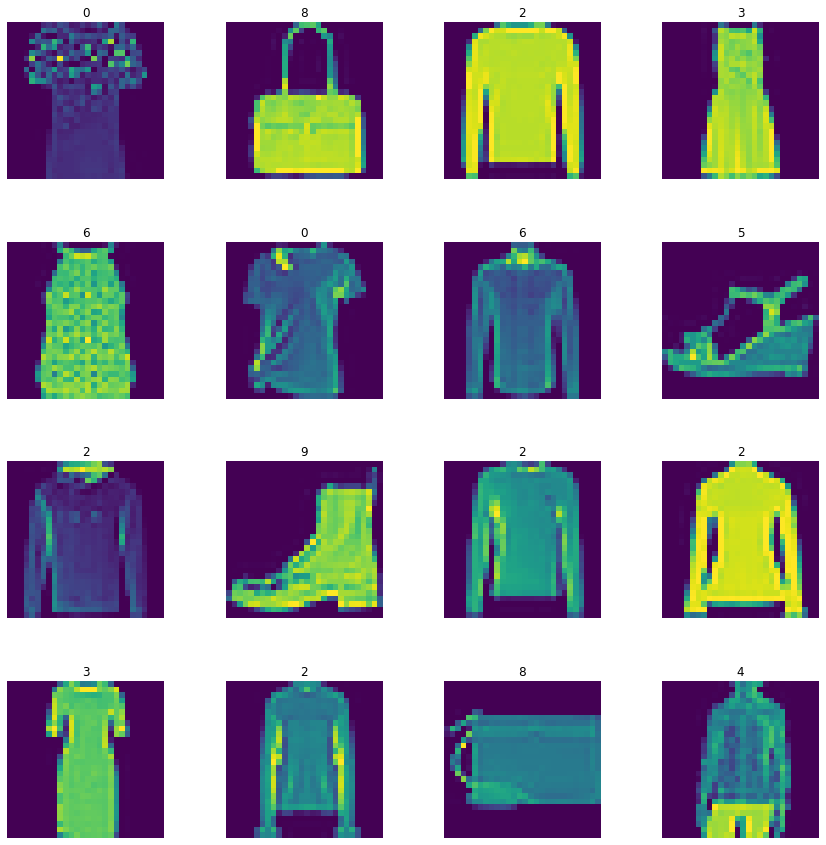

In [75]:
# plot sample of images
plot_img_sample(X_train, Y_train)

# Build, train, test model

In [76]:
# Set hyperparameters
EPOCHS=5 # (int)
VERSION=1 # (int)

# set storage path
MODEL_PATH=tempfile.gettempdir()

# model
MODEL_NAME="img_model"

# Server HOST
HOST="http://localhost"

# Server PORT
PORT=8502

'/tmp'

In [77]:
# define node functions
def build_model():
  cnn = tf.keras.models.Sequential()
  cnn.add(tf.keras.layers.Conv2D(32, (3,3), 
                                activation = "relu",
                                input_shape = (28,28,1)))
  cnn.add(tf.keras.layers.MaxPooling2D(2,2))
  cnn.add(tf.keras.layers.Conv2D(64, (3,3), activation = "relu"))
  cnn.add(tf.keras.layers.Flatten())
  cnn.add(tf.keras.layers.Dense(64, activation = "relu"))
  cnn.add(tf.keras.layers.Dense(10, activation = "softmax"))
  cnn.summary()
  return cnn

def save_model(cnn, save_path):

  # clean up path
  if os.path.exists(save_path):
    print("\nalready saved a model, cleaning up\n")
    shutil.rmtree(save_path)

  # disable eager execution to save model
  if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()
    
  tf.compat.v1.saved_model.simple_save(
      tf.compat.v1.keras.backend.get_session(),
      save_path,
      inputs = {"input_image": cnn.input},
      outputs = {i.name:i for i in cnn.outputs}
  )

In [78]:
# build model
model = build_model()

# compile loss and train 
model.compile(optimizer=tf.compat.v1.train.AdamOptimizer(),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])

# train and evaluate model
model.fit(X_train, Y_train, epochs=EPOCHS)
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"\nTest accuracy: {test_acc}")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_3 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                495680    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 515,146
Trainable params: 515,146
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Test accuracy: 0.9162999987602234


In [80]:
# save model
save_path = os.path.join(MODEL_PATH, str(VERSION))
save_model(model, save_path)


already saved a model, cleaning up

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/1/saved_model.pb


## Serve the model

In [81]:
# inspect saved model
!saved_model_cli show --dir {save_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: conv2d_6_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_7/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: dense_7/Softmax:0
  Method name is: tensorflow/serving/predict


In [82]:
# install tf server packages
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list
!curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -
!sudo apt-get update && sudo apt-get install tensorflow-model-server

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   136k      0 --:--:-- --:--:-- --:--:--  136k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machin

In [83]:
# set model path as environment variavle
os.environ["MODEL_PATH"] = MODEL_PATH

In [89]:
# %%bash --bg  a jupyter magic command, which tells Colab it is a bash script, aims to running in background
# "no hang up", which let's run command immune to hang up.
# Saves the command output in server.log file instead of printing them to stdout. (The output you have added in your question will no longer be visible in UI, but they will be printed in a file)
#
# Expected output: 
#   
  # 2021-10-06 15:56:46.543781: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:283] SavedModel load for tags { serve }; Status: success: OK. Took 134267 microseconds.
  # 2021-10-06 15:56:46.545771: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
  # 2021-10-06 15:56:46.545918: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: img_model version: 1}
  # 2021-10-06 15:56:46.547153: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
  # 2021-10-06 15:56:46.547236: I tensorflow_serving/model_servers/server.cc:133] Using InsecureServerCredentials
  # 2021-10-06 15:56:46.547252: I tensorflow_serving/model_servers/server.cc:383] Profiler service is enabled
  # 2021-10-06 15:56:46.547747: I tensorflow_serving/model_servers/server.cc:409] Running gRPC ModelServer at 0.0.0.0:8500 ...
  # [warn] getaddrinfo: address family for nodename not supported
  # 2021-10-06 15:56:46.548580: I tensorflow_serving/model_servers/server.cc:430] Exporting HTTP/REST API at:localhost:8502 ...
  # [evhttp_server.cc : 245] NET_LOG: Entering the event loop ...
#
# Note: you might need to check that there is not a already running server process running 
# on the rest_api_port (!ps then !kill <PID> if exists)
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8502 \
  --model_name=img_model \
  --model_base_path="${MODEL_PATH}" >server.log 2>&1 # path of model to serve

Starting job # 11 in a separate thread.


In [99]:
!tail server.log

2021-10-06 15:56:46.543781: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:283] SavedModel load for tags { serve }; Status: success: OK. Took 134267 microseconds.
2021-10-06 15:56:46.545771: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2021-10-06 15:56:46.545918: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: img_model version: 1}
2021-10-06 15:56:46.547153: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-10-06 15:56:46.547236: I tensorflow_serving/model_servers/server.cc:133] Using InsecureServerCredentials
2021-10-06 15:56:46.547252: I tensorflow_serving/model_servers/server.cc:383] Profiler service is enabled
2021-10-06 15:56:46.547747: I tensorflow_serving/model_servers/server.cc:409] Running gRPC ModelServer at 0.0.0.0:8500 ...
[warn] getaddrinfo: address family for nodename n

In [105]:
def show(idx, title):
  plt.figure()
  plt.imshow(X_test[idx].reshape(28,28))
  plt.title(f'\n\n{title}', fontdict={'size':16})

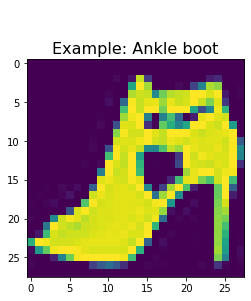

In [108]:
# choose and display an image at random
rando = random.randint(0, len(X_test)-1)
show(rando, f"Example: {class_names[Y_test[rando]]}")b

In [136]:
# select three image instances
data = json.dumps(
    {
        "signature_name": "serving_default",
        "instances": X_test[0:3].tolist()
        }
        )
pp.pprint(f"data: {data[:50]}...{data[len(data)-52:]}")

('data: {"signature_name": "serving_default", "instances":... [0.0], [0.0], '
 '[0.0], [0.0], [0.0], [0.0], [0.0]]]]}')


In [144]:
headers = {"content-type":"applicaton/json"}
json_response = requests.post(
    f"{HOST}:{PORT}/v{VERSION}}/models/{MODEL_NAME}:predict", 
    data=data,
    headers=headers
    )
predictions = json.loads(json_response.text)["predictions"]

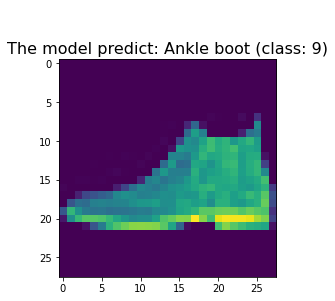

In [150]:
predicted = class_names[np.argmax(predictions[0])]
show(0, f"The model predict: {predicted} (class: {Y_test[0]})")

# References

https://www.youtube.com/watch?v=zpKm8OxDBwE&t=1318s